In [1]:
from pyspark.sql import SparkSession
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer

PROJECT_ROOT = '/home/basal/excelanalysis'
SPARK_NUM_PARTITIONS = 8

DEUTILS_PATH = str(PROJECT_ROOT) + '/resources/DqProfiler-1.0-SNAPSHOT-jar-with-dependencies.jar'
POSTGRES_JDBC = str(PROJECT_ROOT) + '/resources/postgresql-42.3.3.jar'

# .config("spark.sql.shuffle.partitions", f"{SPARK_NUM_PARTITIONS}") \

spark = SparkSession \
.builder \
.appName(f"someThing") \
.config('spark.jars', f"{DEUTILS_PATH},{POSTGRES_JDBC},/home/basal/excelanalysis/resources/geotools-wrapper-1.1.0-25.2.jar,/home/basal/excelanalysis/resources/sedona-python-adapter-3.0_2.12-1.1.1-incubating.jar")\
.config("spark.serializer", KryoSerializer.getName)\
.config("spark.kryo.registrator", SedonaKryoRegistrator.getName)\
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.debug.maxToStringFields', 0) \
.getOrCreate()


22/02/24 16:16:45 WARN Utils: Your hostname, DESKTOP-9QGN9QQ resolves to a loopback address: 127.0.1.1; using 172.21.88.145 instead (on interface eth0)
22/02/24 16:16:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/02/24 16:16:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/24 16:16:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/02/24 16:16:47 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
SedonaRegistrator.registerAll(spark)

True

In [4]:
spark.sql("""
select ST_Distance(
ST_Transform(ST_Point(51.354026080547015, 0.09604635637162225), 'epsg:4326', 'epsg:3857'),
ST_Transform(ST_Point(51.36673093004155, 0.058218264444418015), 'epsg:4326', 'epsg:3857')
)/1609 as distance_in_kms
""").show()

+-----------------+
|  distance_in_kms|
+-----------------+
|2.971717521057653|
+-----------------+



In [1]:
from utils.spark_utils import cleanup_col_name, with_std_column_names, get_spatial_spark_session
from pyspark.sql import functions as f

22/02/25 11:26:01 WARN Utils: Your hostname, DESKTOP-9QGN9QQ resolves to a loopback address: 127.0.1.1; using 172.21.85.55 instead (on interface eth0)
22/02/25 11:26:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/02/25 11:26:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/25 11:26:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
spark=get_spatial_spark_session()

In [4]:
# Get the Schema
df = spark.read.format('csv').option("header", "true").load(f"/mnt/c/users/lohith/Downloads/AllCrime/2019-03")
schema = df.schema

# Read data for all forces under the monthly folders
def get_crime_month(mnth: str):
    df = spark.read.format('csv')\
    .option("header", "true")\
    .schema(schema) \
    .load(f"/mnt/c/users/lohith/Downloads/AllCrime/{mnth}")
    
    crime_df = df\
    .filter("latitude IS NOT NULL OR longitude IS NOT NULL")\
    .transform(with_std_column_names())\
    .withColumn("log", f.expr("CAST(longitude AS DOUBLE)"))\
    .withColumn("lat", f.expr("CAST(latitude AS DOUBLE)"))\
    .withColumn("crime_geo", f.expr("""ST_Transform(ST_Point(lat, log), 'epsg:4326', 'epsg:3857') """)) \
    .selectExpr(
        "month as mnth",
        "crime_type",
        "log",
        "lat",
        "crime_geo"
    )
    
    return crime_df


In [5]:
import pandas as pd
d = pd.date_range(start='1/1/2021', end='12/1/2021', freq='MS')
mnth_range = [x.strftime("%Y")+'-'+x.strftime("%m") for x in d]


In [6]:
df_arry = [get_crime_month(mnth) for mnth in mnth_range]

In [7]:
import functools 
merged_df = functools.reduce(lambda df1, df2: df1.union(df2), df_arry)

In [16]:
# merged_df.cache()
# merged_df.take(1)

22/02/23 00:41:24 WARN CacheManager: Asked to cache already cached data.


[Row(month='2019-01', crime_type='Violence and sexual offences', log=-0.709911, lat=50.784615)]

Attempting distance join

In [8]:
# merged_df.printSchema()
merged_df.rdd.getNumPartitions()

48

In [1]:
spark.stop()

NameError: name 'spark' is not defined

In [9]:
merged_df.coalesce(1)\
.write.format('parquet').mode("overwrite")\
.partitionBy("mnth")\
.save("/mnt/c/users/lohith/Downloads/AllCrimeParquet_bucketed_2021_onefile")

**Query complete crime data using the postcode**

In [6]:
# Can I cache it?
# crime_df = spark.read.load("/mnt/c/users/lohith/Downloads/AllCrimeParquet_bucketed_2021")
crime_df = spark.read.load("/mnt/c/users/lohith/Downloads/AllCrimeParquet_bucketed_2021_onefile")
# crime_df.cache()
# crime_df.take(1)
# crime_df.count()

In [15]:
crime_df.groupBy('mnth').count().show()

KeyboardInterrupt: 

22/02/23 20:18:28 WARN TaskSetManager: Lost task 89.0 in stage 33.0 (TID 727) (172.21.86.57 executor driver): TaskKilled (Stage cancelled)
22/02/23 20:18:28 WARN TaskSetManager: Lost task 90.0 in stage 33.0 (TID 728) (172.21.86.57 executor driver): TaskKilled (Stage cancelled)
22/02/23 20:18:28 WARN TaskSetManager: Lost task 88.0 in stage 33.0 (TID 726) (172.21.86.57 executor driver): TaskKilled (Stage cancelled)
22/02/23 20:18:28 WARN TaskSetManager: Lost task 91.0 in stage 33.0 (TID 729) (172.21.86.57 executor driver): TaskKilled (Stage cancelled)


**Query Single**

In [42]:
crime_df.filter("month like '2020%'").count()
crime_df.cache()
crime_df.take(1)
# 6283637/12

523636.4166666667

In [50]:
crime_df.unpersist()

DataFrame[month: string, crime_type: string, log: double, lat: double, crime_geo: udt]

**Read in PostCode**

In [37]:
from utils.spark_utils import cleanup_col_name, with_std_column_names

postcode_df = spark.read.format('csv').option("header", "true").load("/mnt/c/users/lohith/Downloads/National_Statistics_Postcode_Lookup_UK_Coordinates.csv")

postcode_df = postcode_df\
.filter("latitude IS NOT NULL OR longitude IS NOT NULL")\
.transform(with_std_column_names())\
.withColumn("postcode_geo",f.expr(
    """ ST_Transform(ST_Point(CAST(latitude AS DOUBLE), CAST(longitude AS DOUBLE)), 'epsg:4326', 'epsg:3857')""")
           )\
.selectExpr(
    "postcode_1 as postcode",
    "postcode_geo",
    "local_authority_name"
)

In [38]:
postcode_df.printSchema()

root
 |-- postcode: string (nullable = true)
 |-- postcode_geo: geometry (nullable = false)
 |-- local_authority_name: string (nullable = true)



In [14]:
# spark.read.load("/mnt/c/users/lohith/Downloads/AllCrimeParquet_bucketed_2021_onefile").createOrReplaceTempView("crime")
# spark.read.load("/mnt/c/users/lohith/Downloads/AllCrimeParquet_bucketed_2021_4FILES").createOrReplaceTempView("crime")

In [6]:
cache_df = spark.read.load("/mnt/c/users/lohith/Downloads/AllCrimeParquet_bucketed_2021_4FILES")\
.filter("mnth ='2021-01'")
# cache_df.cache()
# cache_df.take(1)
cache_df.createOrReplaceTempView("crime")

In [7]:
cache_df.count()
# 760,541
# 459,906

459906

In [16]:
def get_crime(lkp_lat, lkp_log):
    df = spark.sql(f"""
    SELECT 
    crime_type,
    CAST(CONCAT(mnth,'-01') AS DATE) AS mnth,
    lat,
    log as lon,
    CONCAT(lat,',',log) AS point,
    ST_Distance(
        crime_geo,
        ST_Transform(ST_Point({lkp_lat},{lkp_log}),'epsg:4326', 'epsg:3857')
        )/1609 AS distance_in_km
    FROM 
    crime
    WHERE ST_Distance(
        crime_geo,
        ST_Transform(ST_Point({lkp_lat},{lkp_log}),'epsg:4326', 'epsg:3857')
        )/1609 < .5   
    """)
    df = df.withColumn("tooltip",f.expr(
        """CONCAT(crime_type, '-', ROUND(distance_in_km,2), ' km away') """)
                       )
    return df

In [168]:
# crime_df.createOrReplaceTempView("crime")

# lkp_lat,lkp_log = 51.354216306966165, 0.09601577404779706
# lkp_lat,lkp_log = 51.36048099880035, -0.08489413540566694 # 1170
    # lkp_lat,lkp_log = 51.36286136475329, -0.09364528500885617 #2000
# 51.39988584782701, 0.017850857899133217 # 336 permonth
lkp_lat,lkp_log=\
51.39477532505466, 0.10633558916633941

# ST_Distance(
#     ST_Transform(ST_Point(lat, log), 'epsg:4326', 'epsg:3857'),
#     ST_Transform(ST_Point({lkp_lat},{lkp_log}),'epsg:4326', 'epsg:3857')
#     )/1609 AS distance_in_km

df = spark.sql(f"""
SELECT 
crime_type,
CONCAT(mnth,'-01') AS mnth,
lat,
log as lon,
CONCAT(lat,',',log) AS point,
ST_Distance(
    crime_geo,
    ST_Transform(ST_Point({lkp_lat},{lkp_log}),'epsg:4326', 'epsg:3857')
    )/1609 AS distance_in_km,
ST_Distance(
    crime_geo,
    ST_Transform(ST_Point({lkp_lat},{lkp_log}),'epsg:4326', 'epsg:3857')
    )/1609*0.621371 AS distance_in_miles
FROM 
crimec
WHERE ST_Distance(
    crime_geo,
    ST_Transform(ST_Point({lkp_lat},{lkp_log}),'epsg:4326', 'epsg:3857')
    )/1609 < .5
    AND mnth IN ('2021-01', '2021-02', '2021-03')      
""")



In [17]:

get_crime(51.39477532505466, 0.10633558916633941).select("mnth").distinct().show()

+----------+
|      mnth|
+----------+
|2021-01-01|
+----------+



In [ ]:
def get_crime_summary(pdf):
    fig = px.histogram(
    pdf
    y='crime_type', 
    color="crime_type",
    )
    fig.update_layout(barmode='group', yaxis={'categoryorder':'total ascending'}, uniformtext_minsize=8)
    fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    return fig

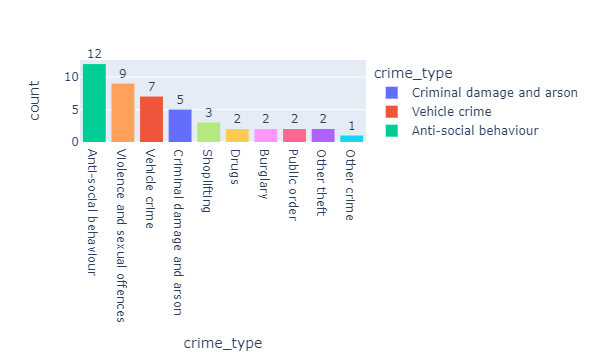

In [35]:
import plotly.express as px
# df.toPandas()
fig = px.histogram(
    get_crime(51.39477532505466, 0.10633558916633941).toPandas(), 
    x='crime_type', 
    color="crime_type",
    text_auto='1s'
)
fig.update_layout( xaxis={'categoryorder':'total descending'}, uniformtext_minsize=8)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()